In [1]:
import tensorflow as tf
import numpy as np
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline

### Load Dataset

우리는 뉴럴넷 모델을 적용하기 전에 데이터 전처리를 해야하며 그 방법에 대해 알아보고 적용시킨다. <br>
모든 Label 에 대한 모델대신 바이너리 분류모델을 만든다.

In [2]:
current_dir = os.getcwd()
data_dir = os.listdir("./train/")

In [3]:
def image_road(data_dir):
    img_matrix = []
    label = []
    index = 0
    for data_label in data_dir:
        category_list = os.listdir(os.getcwd()+"/train/"+data_label)
        for data in category_list:
            img = imread(current_dir+"/train/"+data_label+"/"+data)
            resize_img = imresize(img, [256, 256, 3])
            img_matrix.append(resize_img)
            label.append(index)
        index += 1    
    return img_matrix, label                   

In [4]:
img_matrix, label = image_road(data_dir)

### One-hot encoding
라벨에 대한 정보를 수치화 해야하며 classification 의 경우 One-hot encoding 의 방식을 보편적으로 사용한다. <br>
one-hot encoding 이란 [개, 고양이, 고양이, 개] 의 형식을 [[0,1],[1,0],[1,0],[0,1]] 의 방식으로 표현한 방법이다.

In [5]:
y_data = np.eye(len(data_dir))[label]

### Data argumentation
우리가 이번에 사용하는 데이터는 식물의 잎 모양을 보고 분류하는 모델이다. 그렇다면 어떠한 전처리를 해야 효과적일까. <br>
식물의 잎을 보고 판단을 내려야 한다. 식물의 잎외에 보여지는 이미지는 학습요소가 될 수 없으며 모델의 성능에 악영향을 끼칠것이다. <br>
따라서 우리는 최대한 식물의 잎을 보는 이미지로 전처리 해야하며 이러한 과정은 좋은 모델을 쓰는 것만큼 매우! 중요하다. <br>
데이터 전처리를 하기전 항상 데이터를 들여다보고 어떠한 처리를 해야할 지 생각해야한다. 가장 우선적으로 데이터셋을 살펴보자

Image size : (898, 256, 256, 3)


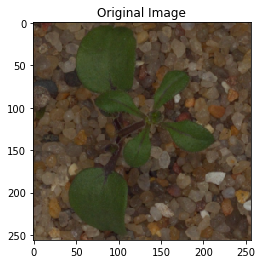

In [6]:
plt.imshow(img_matrix[0])
plt.title("Original Image")
print("Image size :", np.shape(img_matrix))

#### Range of image
RGB 의 3 채널을 가지는 이미지이다. 여기서 각 pixel 들은 0~255 의 범위를 가지고 있다. 하지만 0~255의 범위로 데이터셋이 들어가게 되면 경계면의 pixel 차이가 커지게되고 그것은 weight 들의 element 들이 dense 하지 않는다. 그렇기 때문에 우리는 0~255의 범위를 0~1로 변환한다.

In [7]:
img = np.array(img_matrix)/255
print("change the range of image : \n",img[0,0:3,0:3,0])
print(np.shape(img))

change the range of image : 
 [[ 0.25098039  0.2627451   0.26666667]
 [ 0.24705882  0.24705882  0.25490196]
 [ 0.23137255  0.21568627  0.21176471]]
(898, 256, 256, 3)


### Remove obstacle feature
MNIST 를 생각해보자. MNIST 는 고도로 정제된 데이터셋이다. 우리는 어떠한 객체를 인식하고 분류해야한다. <br>
하지만 위의 데이터셋을 보았을 때 seed 이외의 자갈 등은 학습요소의 저하요인이다. 따라서 이러한 feature 들을 제거해야한다.<br>
각각의 이미지는 RGB 채널로 이루어져 있다. 그렇다면 우리는 G channel 의 값이 충분이 높은 pixel 의 값은 살리고 나머지는 제거한다면 green 의 영역의 pixel 값들만 추출될 것이다.

In [8]:
# RGB channel
for i in range(len(img)):
    row_img = img[i]
    red = row_img[:,:,0]
    green = row_img[:,:,1]
    blue = row_img[:,:,2]
    red_reshape = np.reshape(red, -1)
    green_reshape = np.reshape(green, -1)
    blue_reshape = np.reshape(blue, -1)
    for index, value in enumerate(zip(red_reshape,green_reshape,blue_reshape)):
        if value[1] < 0.20:
            img[i,index//256, index%256, :] = 0
        elif value[0] > 0.30:
            img[i,index//256, index%256, :] = 0
        elif value[2] > 0.20:
            img[i,index//256, index%256, :] = 0

### Check convert image

Text(0.5,1,'Convert remove obstacle feature')

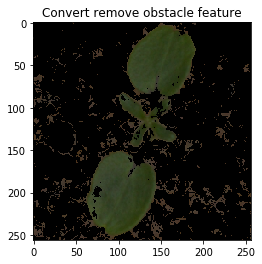

In [9]:
plt.imshow(img[2])
plt.title("Convert remove obstacle feature")

### Data shuffle 
데이터셋의 구성이 0,0,0,0,0,0......1,1,1,1,1,1..... 의 형식으로 데이터의 분포도가 너무 편중되어있다. 이렇게 학습을 하게 되면 모델이 어떠한 답을 찾아내지 않고 편중된 학습을 하게 되므로 데이터를 섞어주어 올바른 feature를 찾아내고 학습할 수 있도록 해야한다.

In [34]:
randidx = np.random.randint(len(img),size=len(img))
shuffle_x = img[randidx,:]
shuffle_y = y_data[randidx,:]

In [35]:
split_value = int(len(img)*0.8)
train_x = shuffle_x[:split_value]
train_y = shuffle_y[:split_value]
test_x = shuffle_x[split_value:]
test_y = shuffle_y[split_value:]

### Set parameter
이제 전처리의 과정은 지났다. 모델을 학습시키기 위해서 파라메터 설정과 모델을 만들자

In [33]:
img_width = np.shape(img)[1]
img_height = np.shape(img)[1]
channel = 3
batch_size = 64
learning_rate = 0.01
epoch = 5

In [15]:
X = tf.placeholder(tf.float32, [None, img_width, img_width, channel])
y = tf.placeholder(tf.float32, [None, 2])
X_img = tf.reshape(X,[-1, img_width*img_height*channel])

### Build model (DNN)
일반적으로 이미지의 학습은 CNN 으로 이루어지지만 기본적으로 DNN에 대해 알아야 하기때문에 DNN 으로 모델을 만든다.

In [19]:
w_1 = tf.get_variable("weight1",shape=[img_width*img_height*channel, 256], initializer=tf.random_normal_initializer())
b_1 = tf.get_variable("bias1", shape=[256,] ,initializer=tf.zeros_initializer())
layer_1 = tf.nn.bias_add(tf.matmul(X_img,w_1),b_1)
layer_1 = tf.nn.relu(layer_1)

w_2 =  tf.get_variable("weight2",shape=[256, 512], initializer=tf.random_normal_initializer())
b_2 = tf.get_variable("bias2", shape=[512,] ,initializer=tf.zeros_initializer())
layer_2 = tf.nn.bias_add(tf.matmul(layer_1,w_2),b_2)
layer_2 = tf.nn.relu(layer_2)

w_3 =  tf.get_variable("weight3",shape=[512, 2], initializer=tf.random_normal_initializer())
b_3 = tf.get_variable("bias3", shape=[2,] ,initializer=tf.zeros_initializer())
layer_3 = tf.nn.bias_add(tf.matmul(layer_2,w_3),b_3)

### Train operation
Loss 와 optimizer 정의한다.

In [31]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=layer_3, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(layer_3, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))    

In [32]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(epoch):
        avg_cost = 0
        total_batch = int(len(train_x)/batch_size)
        for step in range(total_batch):
            randidx = np.random.randint(len(train_x),size=batch_size)
            batch_xs = train_x[randidx,:]
            batch_ys = train_y[randidx,:]
            feed_dict = {X: batch_xs, y: batch_ys}
            c, _ = sess.run([loss, optimizer], feed_dict=feed_dict)
            avg_cost += c / total_batch
        if epoch%5 == 0:
            print("Cost :",avg_cost)
            print("Accuracy :", sess.run(accuracy, feed_dict={X;}))
print('Finished') 

Cost : 6897.41265651

 Accuracy : 0.71875
Cost : 422.829230172

 Accuracy : 0.984375
Cost : 144.995449066

 Accuracy : 1.0
Cost : 56.9956490653

 Accuracy : 0.984375


KeyboardInterrupt: 